In [1]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 733.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from PIL import Image
from tqdm import tqdm
import random
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM

In [3]:
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

In [4]:
from torchvision.transforms import v2

image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(image_net_mean, image_net_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(image_net_mean, image_net_std)
])

In [5]:
def tensor_to_image(image):
    """
    Convert a tensor image back to a displayable image.

    Args:
        image (torch.Tensor): Tensor image to convert.

    Returns:
        numpy.ndarray: Displayable image.
    """
    tensor_image = image.clone().detach()
    tensor_image = tensor_image.reshape(3, 32, 32)
    inverse_normalize = transforms.Normalize(
      mean=[-m/s for m, s in zip(image_net_mean, image_net_std)],
      std=[1/s for s in image_net_std])
    numpy_image = inverse_normalize(tensor_image).permute(1, 2, 0).numpy()
    clipped_image = np.clip(numpy_image, 0, 1)

    return clipped_image

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [7]:
'''
ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class _ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(_ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet(num, num_classes=10):
    if num == 18:
        return _ResNet(BasicBlock, [2,2,2,2], num_classes)
    elif num == 34:
        return _ResNet(BasicBlock, [3,4,6,3], num_classes)
    elif num == 50:
        return _ResNet(Bottleneck, [3,4,6,3], num_classes)
    elif num == 101:
        return _ResNet(Bottleneck, [3,4,23,3], num_classes)
    elif num == 152:
        return _ResNet(Bottleneck, [3,8,36,3], num_classes)
    else:
        raise NotImplementedError

In [8]:
class AddTrigger:
    def __init__(self):
        pass

    def add_trigger(self, img):
        """Add watermarked trigger to image.

        Args:
            img (torch.Tensor): shape (C, H, W).

        Returns:
            torch.Tensor: Poisoned image, shape (C, H, W).
        """
        return self.weight * img + self.res

class AddCIFAR10Trigger(AddTrigger):
    """Add watermarked trigger to CIFAR10 image.

    Args:
        pattern (None | torch.Tensor): shape (3, 32, 32) or (32, 32).
        weight (None | torch.Tensor): shape (3, 32, 32) or (32, 32).
    """

    def __init__(self, pattern, weight):
        super(AddCIFAR10Trigger, self).__init__()

        if pattern is None:
            self.pattern = torch.zeros((1, 32, 32), dtype=torch.uint8)
            self.pattern[0, -3:, -3:] = 1.0
        else:
            self.pattern = pattern
            if self.pattern.dim() == 2:
                self.pattern = self.pattern.unsqueeze(0)

        if weight is None:
            self.weight = torch.zeros((1, 32, 32), dtype=torch.float32)
            self.weight[0, -3:, -3:] = 1.0
        else:
            self.weight = weight
            if self.weight.dim() == 2:
                self.weight = self.weight.unsqueeze(0)

        # Accelerated calculation
        self.res = self.weight * self.pattern
        self.weight = 1.0 - self.weight

    def __call__(self, img):
        img = transforms.functional.to_tensor(img)
        img = self.add_trigger(img)
        img = transforms.ToPILImage()(img)
        return img

In [9]:
class ModifyTarget:
    def __init__(self, y_target):
        self.y_target = y_target

    def __call__(self, y_target):
        return self.y_target

In [10]:
class PoisonedCIFAR10(CIFAR10):
    def __init__(self,
                 benign_dataset,
                 y_target,
                 poisoned_rate,
                 pattern,
                 weight,
                 poisoned_transform_index,
                 poisoned_target_transform_index):
        super(PoisonedCIFAR10, self).__init__(
            benign_dataset.root,
            benign_dataset.train,
            benign_dataset.transform,
            benign_dataset.target_transform,
            download=True)
        total_num = len(benign_dataset)
        poisoned_num = int(total_num * poisoned_rate)
        assert poisoned_num >= 0, 'poisoned_num should greater than or equal to zero.'
        tmp_list = list(range(total_num))
        random.shuffle(tmp_list)
        self.poisoned_set = frozenset(tmp_list[:poisoned_num])

        # Add trigger to images
        if self.transform is None:
            self.poisoned_transform = transforms.Compose([])
        else:
            self.poisoned_transform = copy.deepcopy(self.transform)
        self.poisoned_transform.transforms.insert(poisoned_transform_index, AddCIFAR10Trigger(pattern, weight))

        # Modify labels
        if self.target_transform is None:
            self.poisoned_target_transform = transforms.Compose([])
        else:
            self.poisoned_target_transform = copy.deepcopy(self.target_transform)
        self.poisoned_target_transform.transforms.insert(poisoned_target_transform_index, ModifyTarget(y_target))

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if index in self.poisoned_set:
            img = self.poisoned_transform(img)
            target_pois = self.poisoned_target_transform(target)
            if self.target_transform is not None:
              target = self.target_transform(target)

            return img, target_pois, target

        else:
            if self.transform is not None:
                img = self.transform(img)

            if self.target_transform is not None:
                target = self.target_transform(target)

        return img, target, target


In [11]:
class BadNets:
    """Construct poisoned datasets with BadNets method.

    Args:
        train_dataset: Benign training dataset.
        test_dataset: Benign testing dataset.
        model (torch.nn.Module): Network.
        loss (torch.nn.Module): Loss.
        y_target (int): N-to-1 attack target label.
        poisoned_rate (float): Ratio of poisoned samples.
        pattern (None | torch.Tensor): Trigger pattern, shape (C, H, W) or (H, W).
        weight (None | torch.Tensor): Trigger pattern weight, shape (C, H, W) or (H, W).
        poisoned_transform_train_index (int): The position index that poisoned transform will be inserted in train dataset. Default: 0.
        poisoned_transform_test_index (int): The position index that poisoned transform will be inserted in test dataset. Default: 0.
        poisoned_target_transform_index (int): The position that poisoned target transform will be inserted. Default: 0.
    """

    def __init__(self,
                  train_dataset,
                  test_dataset,
                  model,
                  criterion,
                  y_target,
                  poisoned_rate,
                  pattern=None,
                  weight=None,
                  poisoned_transform_train_index=0,
                  poisoned_transform_test_index=0,
                  poisoned_target_transform_index=0):

        assert pattern is None or (isinstance(pattern, torch.Tensor) and ((0 < pattern) & (pattern < 1)).sum() == 0), 'pattern should be None or 0-1 torch.Tensor.'

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.model = model
        self.criterion = criterion

        self.poisoned_train_dataset = PoisonedCIFAR10(
            train_dataset,
            y_target,
            poisoned_rate,
            pattern,
            weight,
            poisoned_transform_train_index,
            poisoned_target_transform_index)

        self.poisoned_test_dataset = PoisonedCIFAR10(
            test_dataset,
            y_target,
            1.0,
            pattern,
            weight,
            poisoned_transform_test_index,
            poisoned_target_transform_index)

    def train(self, optimizer, device, num_epochs, batch_size, poisoned=False):

        # Place model on device
        model = self.model.to(device)
        if poisoned:
            train_loader = DataLoader(self.poisoned_train_dataset, batch_size=batch_size, shuffle=True)
        else:
            train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):

            self.model.train()  # Set model to training mode

            # Use tqdm to display a progress bar during training
            with tqdm(total=len(train_loader),
                      desc=f'Epoch {epoch + 1}/{num_epochs}',
                      position=0,
                      leave=True) as pbar:
                for item in train_loader:

                    if poisoned:
                        inputs, labels, _ = item
                    else:
                        inputs, labels = item

                    # Move inputs and labels to device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero out gradients
                    optimizer.zero_grad()

                    # Compute the logits and loss
                    logits = self.model(inputs)
                    loss = self.criterion(logits, labels)

                    # Backpropagate the loss
                    loss.backward()

                    # Update the weights
                    optimizer.step()

                    # Update the progress bar
                    pbar.update(1)
                    pbar.set_postfix(loss=loss.item())

            # Evaluate the model on the test set
            avg_loss, accuracy = self.test(device, batch_size, poisoned=False)
            print(
                f'Clean test set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
            )

            avg_loss, accuracy = self.test(device, batch_size, poisoned=True)
            print(
                f'Poisoned test set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
            )


    def test(self, device, batch_size, poisoned=False):
        """
        Evaluate the MLP classifier on the test set.

        Args:
            model (MLP): MLP classifier to evaluate.
            test_loader (torch.utils.data.DataLoader): Data loader for the test set.
            criterion (callable): Loss function to use for evaluation.
            device (torch.device): Device to use for evaluation.

        Returns:
            float: Average loss on the test set.
            float: Accuracy on the test set.
        """
        model = self.model.to(device)
        self.model.eval()  # Set model to evaluation mode

        if poisoned:
            test_loader = DataLoader(self.poisoned_test_dataset, batch_size=batch_size, shuffle=False)
        else:
            test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            total_loss = 0.0
            num_correct = 0
            num_samples = 0

            for item in test_loader:

                if poisoned:
                    inputs, labels, _ = item
                else:
                    inputs, labels = item

                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Compute the logits and loss
                logits = self.model(inputs)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                # Compute the accuracy
                _, predictions = torch.max(logits, dim=1)
                num_correct += (predictions == labels).sum().item()
                num_samples += len(inputs)

        # Compute the average loss and accuracy
        avg_loss = total_loss / len(test_loader)
        accuracy = num_correct / num_samples

        return avg_loss, accuracy

    def predict(self, inputs, device):

        model = self.model.to(device)
        model.eval()

        inputs = inputs.to(device)
        logits = self.model(inputs)
        _, prediction = torch.max(logits, dim=1)

        return prediction


In [12]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
criterion = nn.CrossEntropyLoss()

# Define our trigger pattern (white box in the lower right corner of the image)
pattern = torch.zeros((32, 32), dtype=torch.uint8)
pattern[-3:, -3:] = 1.0

weight = torch.zeros((32, 32), dtype=torch.float32)
weight[-3:, -3:] = 1.0

100%|██████████| 170498071/170498071 [00:13<00:00, 12653363.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
# Train on poisoned dataset with backdoor triggers
model = ResNet(18)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)

badnets = BadNets(
    train_dataset=train_set,
    test_dataset=test_set,
    model=model,
    criterion=criterion,
    y_target=3,
    poisoned_rate=0.05,
    pattern=pattern,
    weight=weight
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Train on clean dataset without triggers
badnets.train(optimizer, device, num_epochs=5, batch_size=64, poisoned=True)

Epoch 1/5: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s, loss=1.07]


Clean test set: Average loss = 0.9828, Accuracy = 0.6556
Poisoned test set: Average loss = 0.1932, Accuracy = 0.9475


Epoch 2/5: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s, loss=0.435]


Clean test set: Average loss = 0.7227, Accuracy = 0.7512
Poisoned test set: Average loss = 0.2371, Accuracy = 0.9483


Epoch 3/5: 100%|██████████| 782/782 [01:00<00:00, 12.93it/s, loss=0.679]


Clean test set: Average loss = 0.6089, Accuracy = 0.7896
Poisoned test set: Average loss = 0.1276, Accuracy = 0.9686


Epoch 4/5: 100%|██████████| 782/782 [01:00<00:00, 12.91it/s, loss=1.09]


Clean test set: Average loss = 0.5472, Accuracy = 0.8163
Poisoned test set: Average loss = 0.1620, Accuracy = 0.9643


Epoch 5/5: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s, loss=0.589]


Clean test set: Average loss = 0.5440, Accuracy = 0.8164
Poisoned test set: Average loss = 0.2992, Accuracy = 0.9464


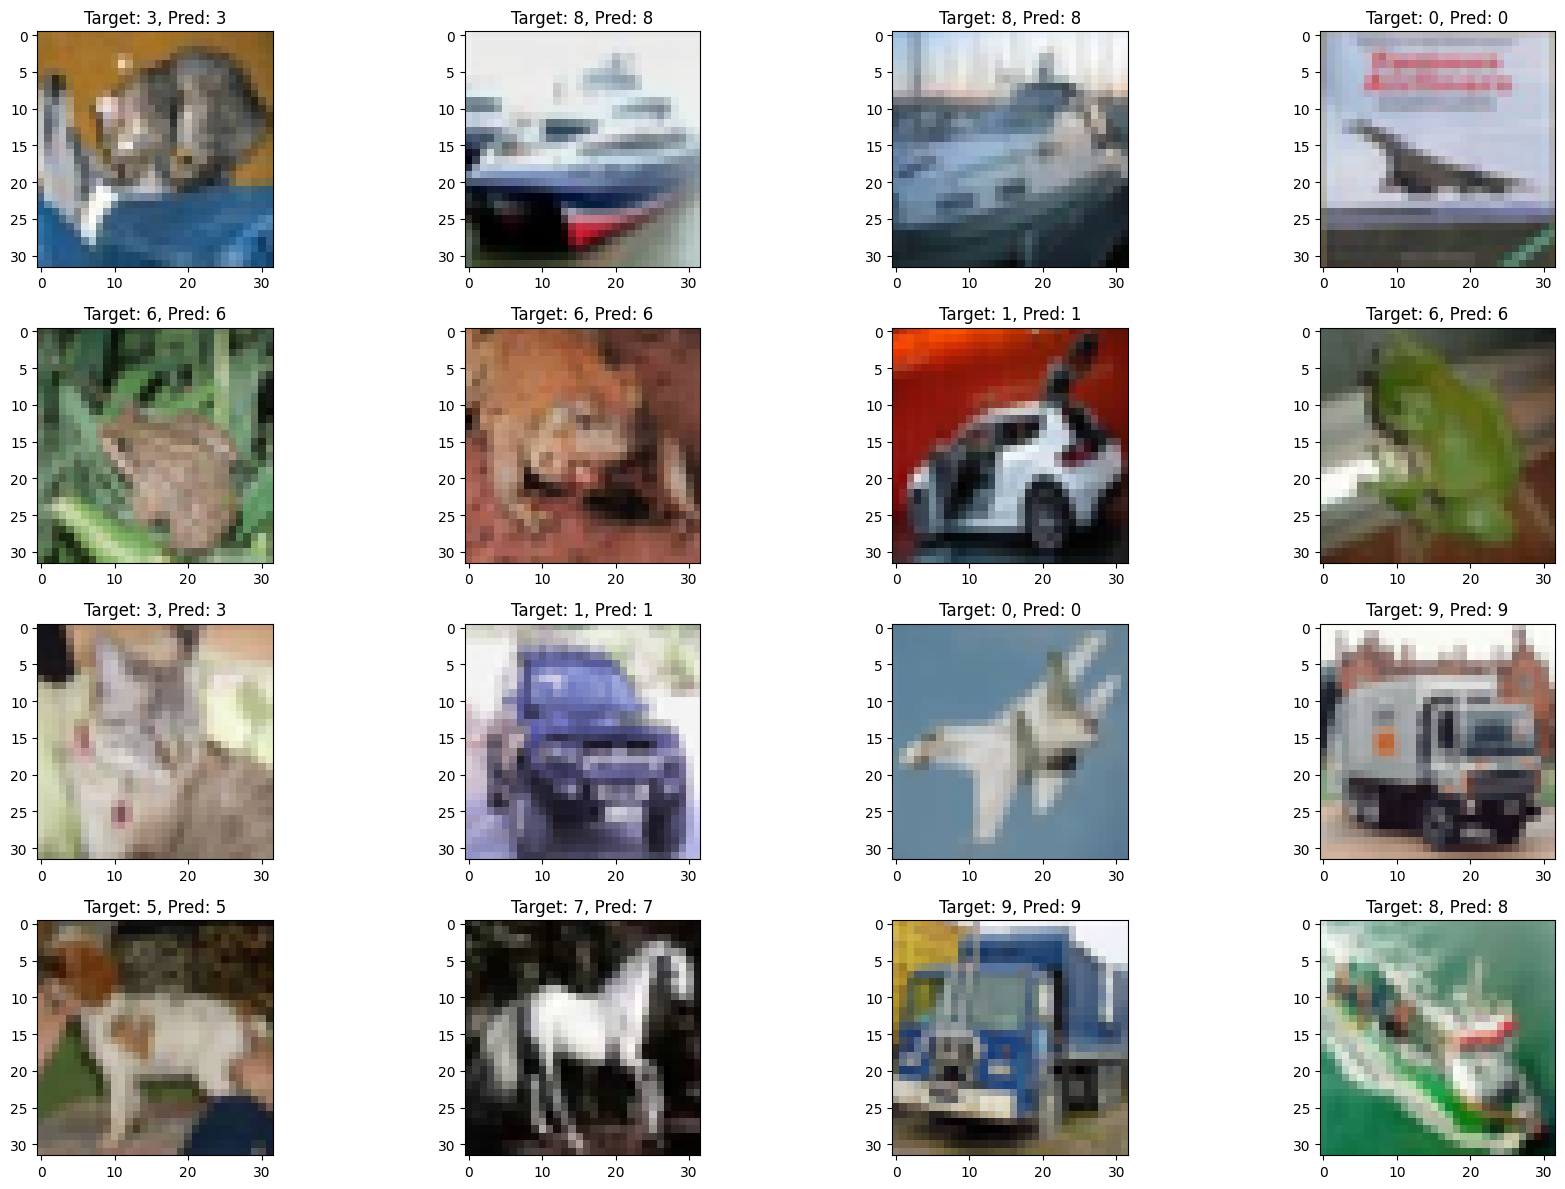

In [15]:
# Visualize predictions from the clean testset
dataloader = DataLoader(badnets.test_dataset, batch_size=64, shuffle=False)

for images, targets in dataloader:

    predictions = badnets.predict(images, device)
    fig, axes = plt.subplots(4, 4, figsize=(18, 12))

    for i, ax in enumerate(axes.flat):
        img = tensor_to_image(images[i])
        ax.imshow(img)
        ax.set_title(f'Target: {targets[i]}, Pred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

    break

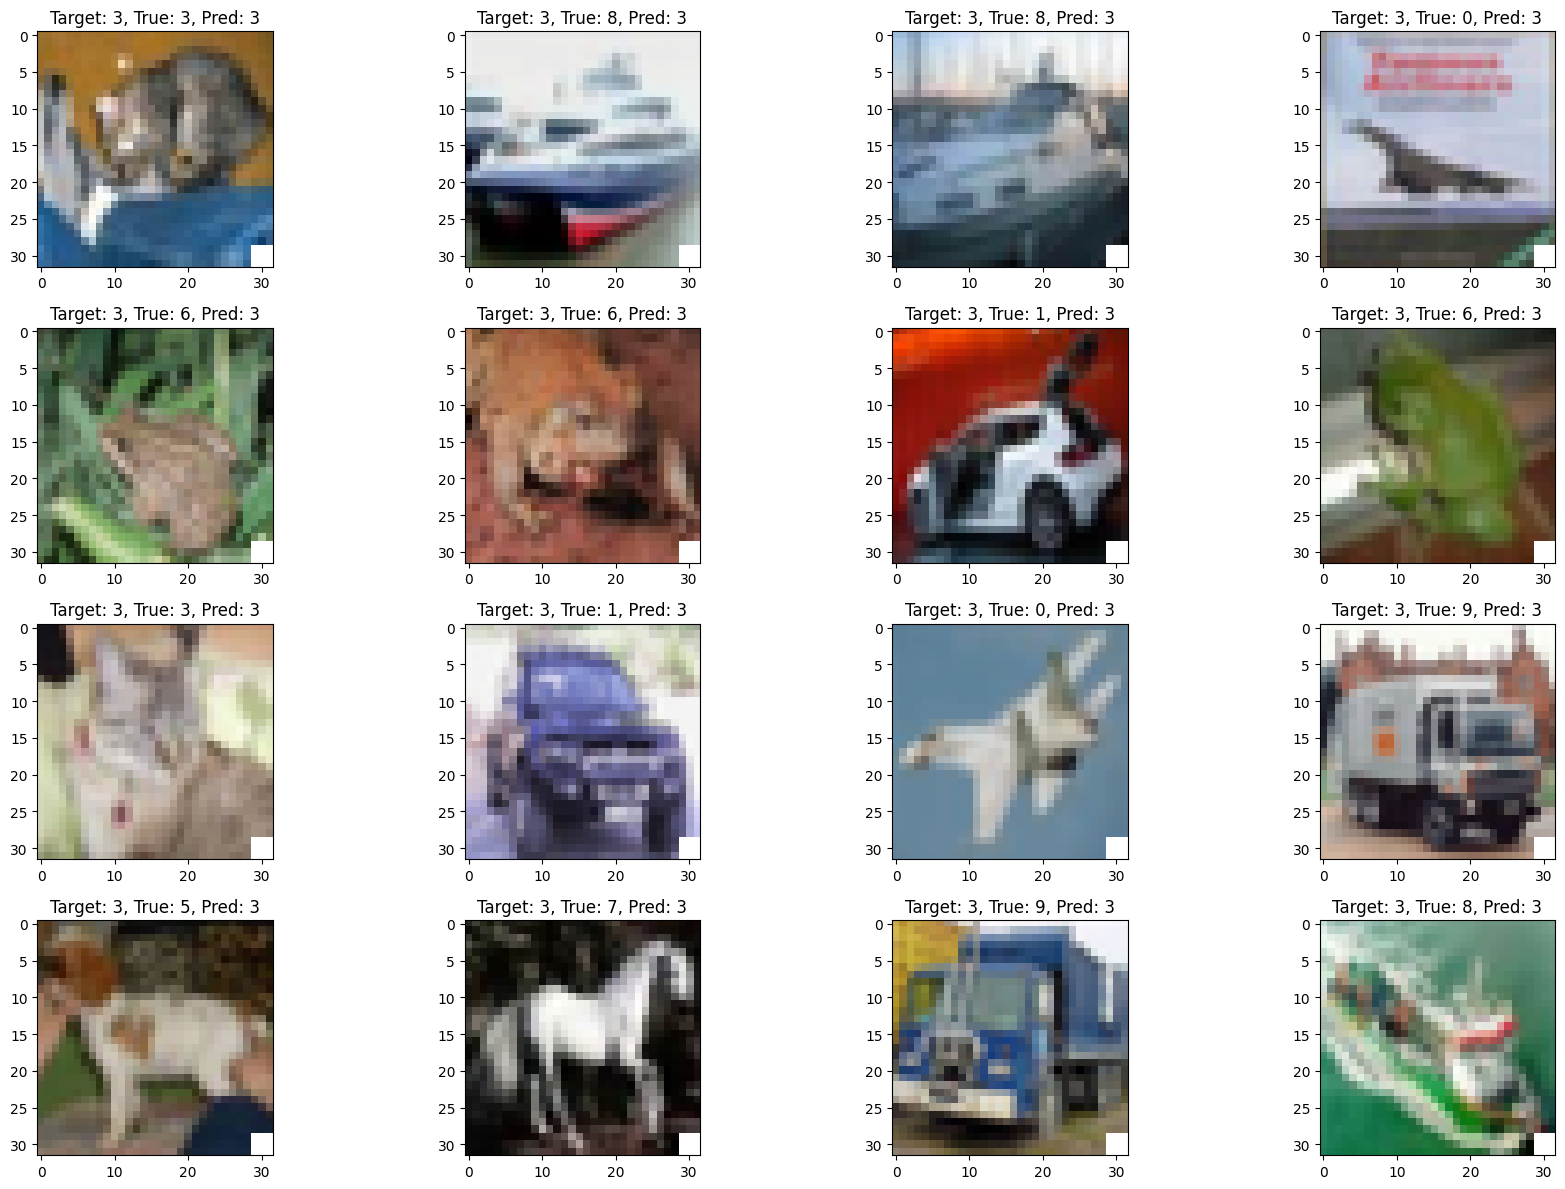

In [16]:
# Visualize predictions from the poisoned testset. Goal is to always predict y_target set during initialization of BadNets
dataloader = DataLoader(badnets.poisoned_test_dataset, batch_size=64, shuffle=False)

for images, targets, ground_truth in dataloader:

    predictions = badnets.predict(images, device)
    fig, axes = plt.subplots(4, 4, figsize=(18, 12))

    for i, ax in enumerate(axes.flat):
        img = tensor_to_image(images[i])
        ax.imshow(img)
        ax.set_title(f'Target: {targets[i]}, True: {ground_truth[i]}, Pred: {predictions[i]}')

    plt.tight_layout()
    plt.show()

    break

In [ ]:
# Apply GradCAM to make model explainable.
target_layers = [badnets.model.layer4]

dataloader = DataLoader(badnets.test_dataset, batch_size=64, shuffle=False)
input_tensor, labels = next(iter(dataloader))

# Construct the CAM object once, and then re-use it on many images
cam = GradCAM(model=badnets.model, target_layers=target_layers)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor)

predictions = badnets.predict(input_tensor, device)
fig, axes = plt.subplots(4, 4, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    img = tensor_to_image(input_tensor[i])
    ax.imshow(img)
    ax.imshow(grayscale_cam[i, :], alpha=0.7, cmap='viridis')
    ax.set_title(f'T: {labels[i]}, Pred: {predictions[i]}')

plt.tight_layout()
plt.show()

In [ ]:
# Apply GradCAM to make model explainable. Notice that for most poisoned images, classifier focus on the trigger in lower right corner
target_layers = [badnets.model.layer4]

dataloader = DataLoader(badnets.poisoned_test_dataset, batch_size=64, shuffle=False)
input_tensor, targets, ground_truth = next(iter(dataloader))

# Construct the CAM object once, and then re-use it on many images
cam = GradCAM(model=badnets.model, target_layers=target_layers)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor)

predictions = badnets.predict(input_tensor, device)
fig, axes = plt.subplots(4, 4, figsize=(18, 12))

for i, ax in enumerate(axes.flat):
    img = tensor_to_image(input_tensor[i])
    ax.imshow(img)
    ax.imshow(grayscale_cam[i, :], alpha=0.7, cmap='viridis')
    ax.set_title(f'Target: {targets[i]}, True: {ground_truth[i]}, Pred: {predictions[i]}')

plt.tight_layout()
plt.show()